In [32]:
import pandas as pd
import numpy as np
import warnings
import itertools

from matplotlib import pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import TimeSeriesSplit

from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
data = pd.read_csv('./data/ghana_gdp.csv',index_col='year',parse_dates=['year'])

data.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


## Статистические модели прогнозирования. Практика
### План работы (перечень последовательно решаемых задач):
1. Отложите последние три года датасета как тестовую выборку для оценки результатов предсказания.
2. Постройте модель скользящего среднего, проанализируйте результат. Для построения ***MA*** используйте метод `rolling`, который принимает в качестве параметра размер окна. Используйте среднее как функцию для сглаживания. Ширину окна подберите самостоятельно.
> Пример: `train_df.spx.rolling(window=2).mean()`.

3. Оцените стационарность временного ряда и примите решение о выборе модели ***ARMA/ARIMA***. Выберите парамeтры ***p*** и ***q*** по коррелограммам ***ACF*** и ***PACF***. Также постройте модель с параметрами, ближайшими к ***p*** и ***q***, и сравните коэффициент ***AIC*** или подберите наилучшие параметры с помощью ***pmdarima***, как в скринкасте.
4. Постройте модель с наилучшими параметрами и выполните предсказание на три года.
5. Отобразите результат графически.
6. Сделайте выводы.

<span style="color: gray">1. Отложите последние три года датасета как тестовую выборку для оценки результатов предсказания.<span>

In [3]:
test = data.iloc[-3:]
train = data.iloc[:-3]

<span style="color: gray">2. Постройте модель скользящего среднего, проанализируйте результат.<span>

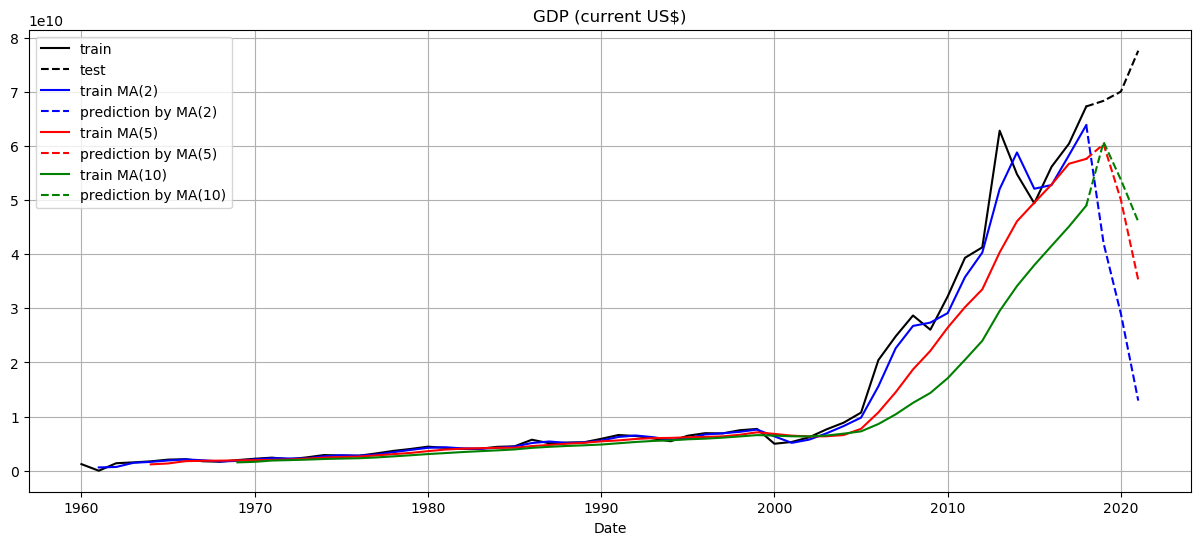

In [4]:
plt.figure(figsize=(15,6))
plt.title('GDP (current US$)')
plt.xlabel('Date')
plt.grid(True)

plt.plot(train,color='black',linestyle='-')
plt.plot(train.iloc[[-1]].append(test),color='black',linestyle='--')
windows = [2,5,10]
colors = ['blue','red','green']

start,end = test.index[0], test.index[-1]

for window,color in zip(windows,colors):
    row = train.rolling(window=window,).mean()
    plt.plot(row,color=color,linestyle='-')
    
    ma = ARIMA(train,order=(0, 0, window),freq='AS')
    ma_mod = ma.fit()    
    pred_test = pd.DataFrame(ma_mod.predict(start,end))
    pred_test.columns = ['GDP (current US$)']
    plt.plot(row.iloc[[-1]].append(pred_test),color=color,linestyle='--')    

legends = ['train', 'test'] + \
[str(xx) + str(x) + ')' for x in windows for xx in ['train MA(','prediction by MA(']] 
plt.legend(legends);

Как видим .....

<span style="color: gray">3. Оцените стационарность временного ряда и примите решение о выборе модели **ARMA/ARIMA**. Выберите парамeтры **p** и **q** по коррелограммам **ACF** и **PACF**. Также постройте модель с параметрами, ближайшими к **p** и **q**, и сравните коэффициент **AIC** или подберите наилучшие параметры с помощью `pmdarima`, как в скринкасте.</span>   
   

Оценим стационарность воспользовавшись тестом Дики-Фуллера.

In [5]:
print (f'P-value сставляет {adfuller(train)[1]:.3f}')

P-value сставляет 0.989


P-value многократно превышает самый толерантный уровень знчимости 0.1, так что нулевая гипотеза теста Дики-Фуллера о нестационарнотси ряда остается неотвергнутой. Поэтому наш выбор - **ARIMA**.       

Сначала определим для модели параметр **d**.

In [6]:
significance = 0.1
train_diff = train.copy()

for d in range(10):
    if adfuller(train_diff)[1] < significance:
        break
    train_diff = train_diff.diff(periods=1).dropna()
    
print(f'При уровне значимости {significance} параметр d = {d}')

При уровне значимости 0.1 параметр d = 2


Теперь определим параметры **p** и **q** по коррелограммам **ACF** и **PACF**.

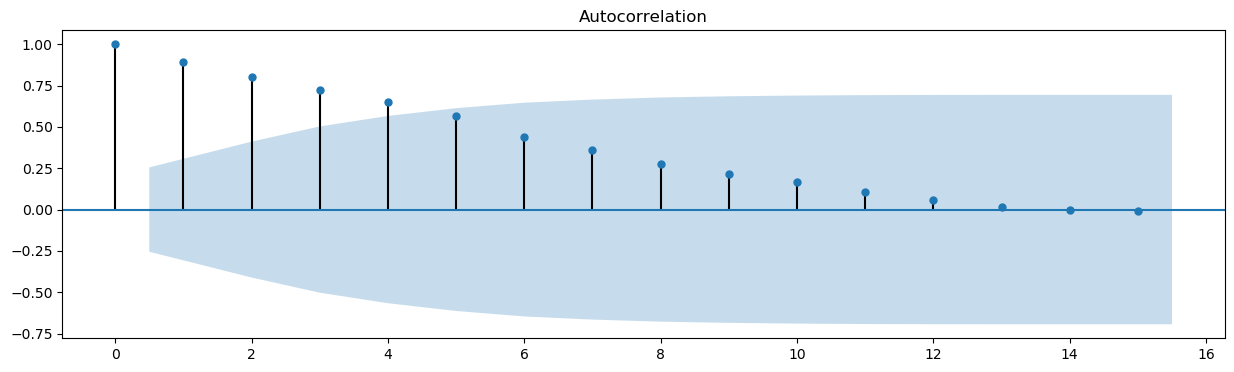

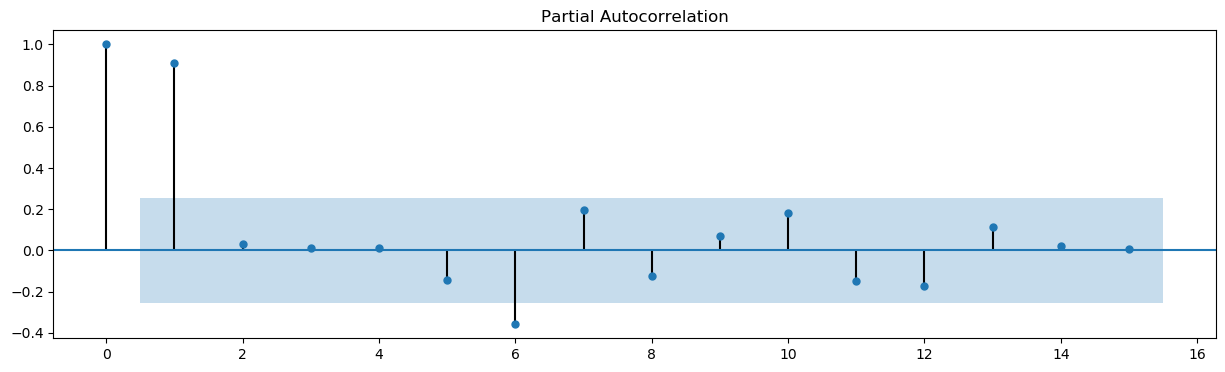

In [7]:
fig_acf = plot_acf(train,lags=15)
fig_acf.set_size_inches(15,4)

fig_pacf = plot_pacf(train,lags=15)
fig_pacf.set_size_inches(15,4)

plt.show()

Выберем **p** = 4, **q** = 6.   
    
В качестве параметров для альтернативных моделей возьмем диапазоны:    
**pp** = range(1,9), **dd** = range(1,9), **qq** = range(9)   

In [25]:
# %%time
pp, dd, qq = range(1,8), range(0,5), range(1,9)
aic_series = pd.Series()

for p,d,q in itertools.product(pp, dd, qq, repeat=1):
    mod = ARIMA(train,order=(p,d,q),freq='AS')
    res = mod.fit()
    aic_series = aic_series.append(pd.Series(index = [(p,d,q)], data=res.aic))
    
print('При p=4, d=2, q=6  Знвчение  AIC = {:.3f}\n'.format(aic_series[(4,2,6)]))
print('Минимальное значение AIC = {:.3f} в рассмотренном диапазоне параметров достигается \
при p={} d={} q={}'.format(aic_series.min(),*aic_series.idxmin()))
print('\nСреднее значение AIC = {:.3f} '.format(aic_series.median()))
print('Медианное значение AIC = {:.3f} '.format(aic_series.mean()))
print('Маскимальное значение AIC = {:.3f} '.format(aic_series.max()))

При p=4, d=2, q=6  Знвчение  AIC = 2684.012

Минимальное значение AIC = 2588.429 в рассмотренном диапазоне параметров достигается при p=7 d=4 q=5

Среднее значение AIC = 2682.433 
Медианное значение AIC = 2694.677 
Маскимальное значение AIC = 2799.294 


...

<span style="color: gray">4. Постройте модель с наилучшими параметрами и выполните предсказание на три года.<span>

In [9]:
best_p, best_d, best_q = aic_series.idxmin()

best_mod = ARIMA(train,order=(best_p, best_d, best_q ),freq='AS')
best_res = best_mod.fit()

best_mod_pred = pd.DataFrame(best_res.forecast(3))
best_mod_pred.columns = ['GDP (current US$)']

<span style="color: gray">5. Отобразите результат графически.<span>

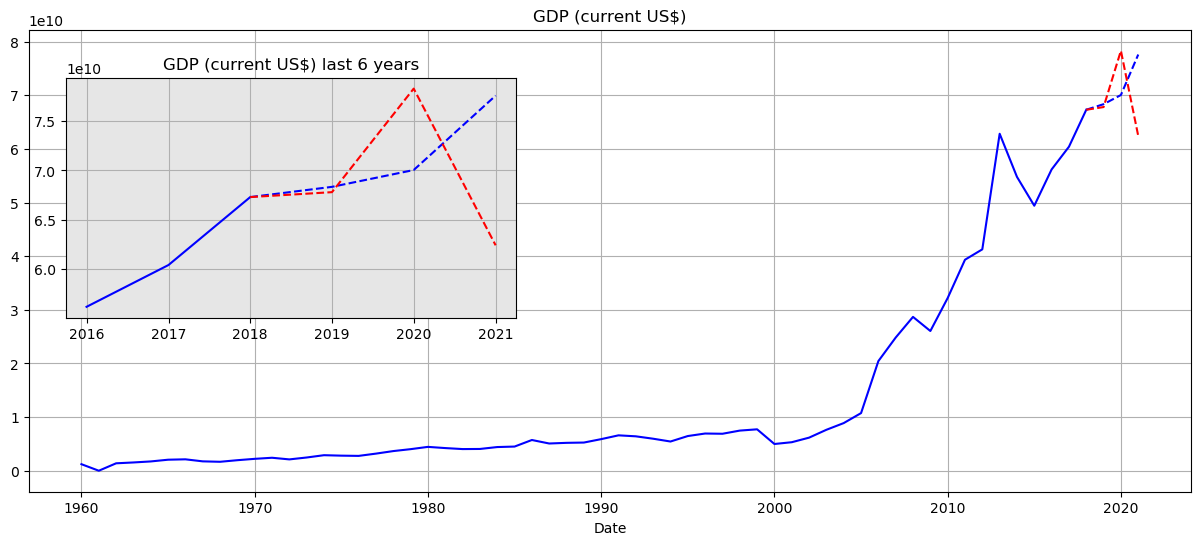

In [10]:
fig = plt.figure(figsize=(15,6))
plt.title('GDP (current US$)')
plt.xlabel('Date')
plt.grid(True)

plt.plot(train,color='blue',linestyle='-')
plt.plot(train.iloc[[-1]].append(test),color='blue',linestyle='--')
plt.plot(train.iloc[[-1]].append(pd.DataFrame(best_mod_pred)),color='red',linestyle='--')

ax_ins = fig.add_axes([0.15, 0.4, 0.3, 0.4])
ax_ins.set_facecolor('0.9')
plt.title('GDP (current US$) last 6 years')
plt.grid(True)
plt.plot(train.iloc[-3:],color='blue',linestyle='-')
plt.plot(train.iloc[[-1]].append(test),color='blue',linestyle='--')
plt.plot(train.iloc[[-1]].append(pd.DataFrame(best_mod_pred)),color='red',linestyle='--')
plt.show()

<span style="color: gray">6. Сделайте выводы.<span>
    
...

## Интерполяция и сэмплирование. Практика
### План работы (перечень последовательно решаемых задач):

1. Проверьте данные на наличие пропущенных дат. Помимо визуального способа, это можно сделать с помощью метода `Series.asfreq()`, передав в него параметр частоты, например ‘d’ — день, ‘m’ — месяц. Все алиасы для параметров частоты доступны по [ссылке](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases).
>Подсказка
df.asfreq(freq='AS')
2. Проверьте данные на наличие пропущенных значений `(Series.isna().sum())`.
3. Обратите внимание, что иногда пропуски в данных могут быть заполнены нулями. Сделайте проверку на наличие нулевых значений и в случае нахождения замените их на `NaN`. Воспользуйтесь кодом ниже:
```python 
import numpy as np
df['GDP (current US$)'] = df['GDP (current US$)'].apply(lambda x: np.nan if x==0 else x)
```
4. Для заполнения пропусков выполните интерполяцию с использованием метода `.interpolate()`.
>Подсказка
df['GDP (current US$)'].interpolate(method='linear')

5. Проверьте полученный ряд на стационарность, определите параметры модели ***(ARIMA/ARMA)*** и запустите модель.
6. Изменился ли ***AIC*** критерий построенной модели по сравнению с моделью на неинтерполированных данных? Сделайте вывод.

<span style="color: gray">1. Проверьте данные на наличие пропущенных дат.<span>

In [11]:
 train.asfreq(freq='AS').isna().values.sum()

0

<span style="color: gray">2. Проверьте данные на наличие пропущенных значений.<span>

In [12]:
train.isna().sum()

GDP (current US$)    0
dtype: int64

<span style="color: gray">3. Сделайте проверку на наличие нулевых значений и в случае нахождения замените их на `NaN`.<span>

In [13]:
(train['GDP (current US$)'] == 0).sum()

1

In [14]:
train[train['GDP (current US$)'] == 0] = np.NaN

<span style="color: gray">4. Для заполнения пропусков выполните интерполяцию<span>

In [17]:
train['GDP (current US$)'].interpolate(method='linear',inplace=True)

<span style="color: gray">5. Проверьте полученный ряд на стационарность, определите параметры модели ***(ARIMA/ARMA)*** и запустите модель.<span>

In [19]:
print (f'P-value сставляет {adfuller(train)[1]:.3f}')

P-value сставляет 0.992


In [31]:
significance = 0.1
train_diff = train.copy()

for d in range(10):
    if adfuller(train_diff)[1] < significance:
        break
    train_diff = train_diff.diff(periods=1).dropna()
    
print(f'При уровне значимости {significance} параметр d = {d}')

При уровне значимости 0.1 параметр d = 2


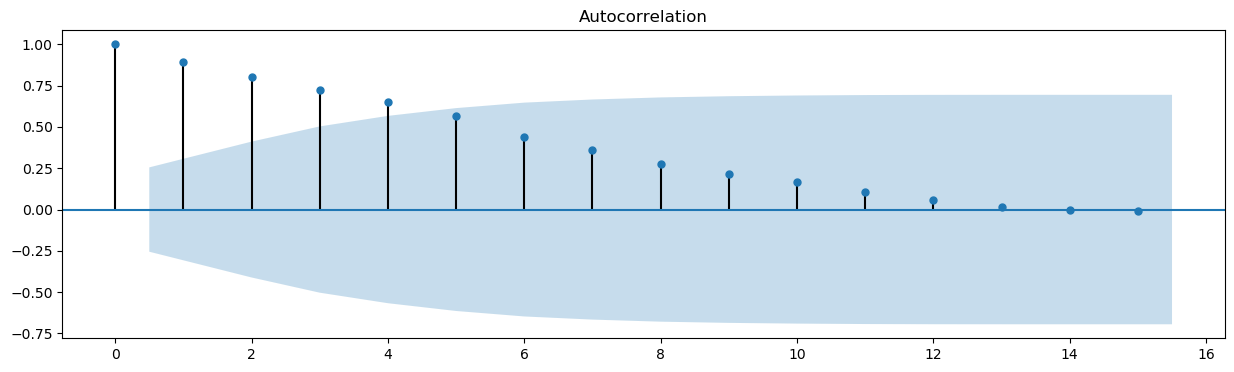

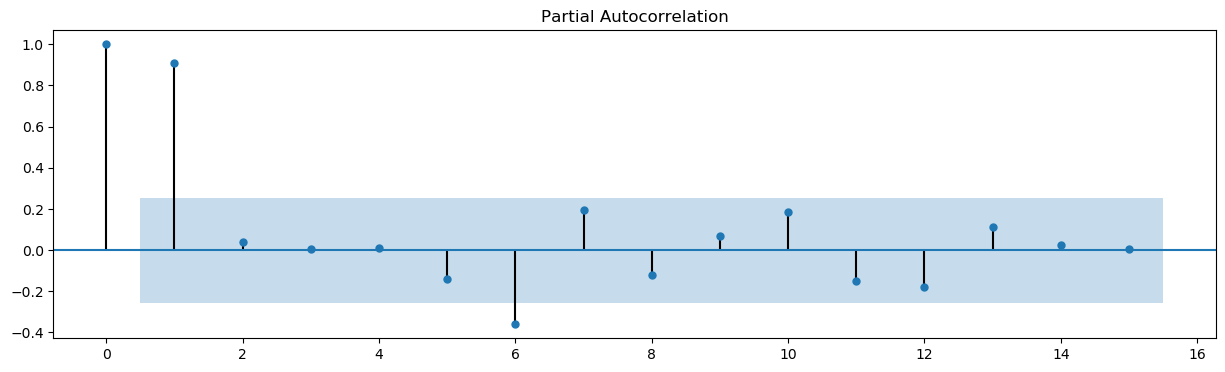

In [20]:
fig_acf = plot_acf(train,lags=15)
fig_acf.set_size_inches(15,4)

fig_pacf = plot_pacf(train,lags=15)
fig_pacf.set_size_inches(15,4)

plt.show()

In [27]:
pp, dd, qq = range(1,8), range(0,5), range(1,9)
inter_aic_series = pd.Series()

for p,d,q in itertools.product(pp, dd, qq, repeat=1):
    mod = ARIMA(train,order=(p,d,q),freq='AS')
    res = mod.fit()
    inter_aic_series = inter_aic_series.append(pd.Series(index = [(p,d,q)], data=res.aic))

<span style="color: gray">6. Изменился ли ***AIC*** критерий построенной модели по сравнению с моделью на неинтерполированных данных? Сделайте вывод.<span>

In [28]:
print('Минимальное значение AIC = {:.3f} в рассмотренном диапазоне параметров достигается \
при p={} d={} q={}'.format(inter_aic_series.min(),*inter_aic_series.idxmin()))

print('Минимальное значение AIC = {:.3f} в рассмотренном диапазоне параметров достигается \
при p={} d={} q={}'.format(aic_series.min(),*aic_series.idxmin()))

Минимальное значение AIC = 2588.429 в рассмотренном диапазоне параметров достигается при p=7 d=4 q=5
Минимальное значение AIC = 2588.429 в рассмотренном диапазоне параметров достигается при p=7 d=4 q=5


...

## Валидация временных рядов
### Задание 8.3

![](https://lms.skillfactory.ru/assets/courseware/v1/8016a5615b36084c9633c70a9648f8b3/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/MATHML_md13_8_4.png)


1. Разбейте временной ряд на три набора (3 train + 3 test). Для этого воспользуйтесь классом TimeSeriesSplit из sklearn.model_selection с параметрами n_splits=3 и test_size=7 (или max_train_size=df.sales.count()-7). Наборы данных можно получить, вызвав метод split (временной ряд) у инициализированного TimeSeriesSplit.    
    
    Пример кода:
```python
tscv = TimeSeriesSplit(...)
```
2. Выведите размеры полученных подвыборок:
```python
train_test_groups = tscv.split(df.sales) 
for train_index, test_index in train_test_groups:
    print("TRAIN size:", len(train_index), "TEST size:", len(test_index))
```
    
Обратите внимание на отличие в размерах выборок на рисунке с walk forward validation и множественным разбиением. В задании вы вывели размеры полученных выборок. Какой случай вы получили?

In [68]:
tscv = TimeSeriesSplit(n_splits=3,max_train_size=len(data)-7)

train_test_groups = tscv.split(data)

for train_index, test_index in train_test_groups:
 print("TRAIN size:", len(train_index), "TEST size:", len(test_index))

TRAIN size: 17 TEST size: 15
TRAIN size: 32 TEST size: 15
TRAIN size: 47 TEST size: 15


## ===== ПОДВАЛ =====

In [10]:
pp, dd, qq = range(1,6), range(1,5), range(4)
aic_series = pd.Series()

for p,d,q in itertools.product(pp, dd, qq, repeat=1):
    mod = ARIMA(train,order=(p,d,q),freq='AS')
    res = mod.fit()
    aic_series = aic_series.append(pd.Series(index = [(p,d,q)], data=res.aic))

print('Минимальное значение AIC в рассмотренном диапазоне параметров достигается \
при p={} d={} q={}'.format(*aic_series.idxmin()))

Минимальное значение AIC в рассмотренном диапазоне параметров достигается при p=5 d=4 q=2


In [11]:
pp, dd, qq = range(1,6), range(1,5), range(4)
aic_series = pd.Series()

for p,d,q in itertools.product(pp, dd, qq, repeat=1):
#     print (p,d,q, end=' : ')
    mod = ARIMA(train,order=(p,d,q),freq='AS')
    res = mod.fit()
#     print(res.aic)
#     print(pd.Series(index = [(p,d,q)], data=res.aic))
    aic_series = aic_series.append(pd.Series(index = [(p,d,q)], data=res.aic))
    
aic_series.idxmin()

(5, 4, 2)

In [12]:
aic_series.idxmin()

(5, 4, 2)

In [13]:
# # MA example
# from statsmodels.tsa.arima_model import ARMA
# from random import random
# # contrived dataset
# data = [x  for x in range(1, 40)] # + random()
# # fit model
# model = ARMA(data, order=(0,10))
# model_fit = model.fit(disp=False)
# # make prediction
# yhat = model_fit.predict(len(data), len(data)+10)
# print(yhat)
# data

In [14]:
plt.rcParams.keys

<bound method Mapping.keys of RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-7, 7],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_matht

In [15]:
# plt.figure(figsize=(15,8))
# plt.title('GDP (current US$)')
# plt.xlabel('Date')
# plt.grid(True)
# plt.yscale('log')

# plt.plot(train)

# for window in [2,3,5,10]:
#     row = train.rolling(window=window).mean()
#     plt.plot(row)
    
# plt.legend(['original data'] + [f'MA({str (x)})' for x in [2,3,5,10]]);

In [16]:
# significance = 0.05
# inference = 'не может быть отвергнута' if p_value>significance else 'отверграется'
# print (f'p-value составляет {p_value:.3f}, а потомму нулевая гипотеза {inference}')

train_diff_1 = train.diff(periods=1).dropna()
print (f'P-value сставляет {adfuller(train_diff_1)[1]:.3f}')

train_diff_2 = train_diff_1.diff(periods=1).dropna()
print (f'P-value сставляет {adfuller(train_diff_2)[1]:.3f}')

In [17]:
# p,d,q = 4,2,1
# p_alt_1,d_alt_1,q_alt_1 = 5,3,2
# p_alt_2,d_alt_2,q_alt_2 = 3,1,0

# mod = ARIMA(train,order=(p,d,q),freq='AS')
# mod_alt_1 = ARIMA(train,order=(p_alt_1,d_alt_1,q_alt_1),freq='AS')
# mod_alt_2 = ARIMA(train,order=(p_alt_2,d_alt_2,q_alt_2),freq='AS')

# res = mod.fit()
# res_alt_1 = mod_alt_1.fit()
# res_alt_2 = mod_alt_2.fit()

# res.aic,res_alt_1.aic,res_alt_2.aic

In [26]:
# plt.figure(figsize=(15,6))
# plt.title('GDP (current US$)')
# plt.xlabel('Date')
# plt.grid(True)

# plt.plot(train['GDP (current US$)'],color='blue',linestyle='-')
# plt.plot(train['GDP (current US$)'].iloc[[-1]].append(test['GDP (current US$)']),color='blue',linestyle='--')

# plt.plot(train['GDP (current US$)'].iloc[[-1]].append(pred_test),color='red',linestyle='--')